In [1]:
import ast
import csv
import gc
import json
import os
import sys
from pprint import pprint
from timeit import default_timer as timer
from glob import glob

import numpy as np
import pandas as pd
# import shap
import xgboost as xgb
from IPython.display import display
from hyperopt import STATUS_OK, hp
from hyperopt import atpe, tpe, Trials, fmin
from hyperopt.pyll.stochastic import sample
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_sample_weight
from matplotlib import pyplot as plt

main_dir = os.path.abspath(os.pardir)
sys.path.insert(0, main_dir)

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 100
pd.options.display.max_colwidth = 100
pd.options.display.precision = 8
pd.options.display.float_format = '{:,.3f}'.format

data_path = os.path.join(main_dir, "data")+os.sep
interim_path = os.path.join(data_path, "interim")+os.sep
processed_path = os.path.join(data_path, "processed")+os.sep
models_path = os.path.join(main_dir, "models")+os.sep
predictions_path = os.path.join(main_dir, "models", "predictions")+os.sep
ml_data_fname = "ml_data.gzip"
gbm_trials_fname = 'gbm_trials.csv'
dt_ftm = "%Y/%m/%d, %H:%M:%S"
target = "class"

In [2]:
csv_files = pd.Series(glob(processed_path+"*.gzip"))
csv_files

0      D:\Users\gjnet\code_projects\kaggle_ccs\data\processed\complete_test.gzip
1     D:\Users\gjnet\code_projects\kaggle_ccs\data\processed\complete_train.gzip
2           D:\Users\gjnet\code_projects\kaggle_ccs\data\processed\f0_train.gzip
3             D:\Users\gjnet\code_projects\kaggle_ccs\data\processed\f0_val.gzip
4           D:\Users\gjnet\code_projects\kaggle_ccs\data\processed\f1_train.gzip
5             D:\Users\gjnet\code_projects\kaggle_ccs\data\processed\f1_val.gzip
6           D:\Users\gjnet\code_projects\kaggle_ccs\data\processed\f2_train.gzip
7             D:\Users\gjnet\code_projects\kaggle_ccs\data\processed\f2_val.gzip
8           D:\Users\gjnet\code_projects\kaggle_ccs\data\processed\f3_train.gzip
9             D:\Users\gjnet\code_projects\kaggle_ccs\data\processed\f3_val.gzip
10          D:\Users\gjnet\code_projects\kaggle_ccs\data\processed\f4_train.gzip
11            D:\Users\gjnet\code_projects\kaggle_ccs\data\processed\f4_val.gzip
dtype: object

In [3]:
def safe_downcast(series_in, num_type):
    series_out = pd.to_numeric(series_in, downcast=num_type)
    if not np.equal(series_in, series_out).all():
        series_out = series_in
    return series_out

In [4]:
dfs = dict()
drop_cols = ["type","add","flip","img_id","rot_id", "grp_key", "img_grp"]

for file in csv_files:
    short_fname = file.rsplit('\\', 1)[-1].replace(".gzip", "")
    print("Reading file", short_fname+".gzip", end=" ")
    dfs[short_fname] = pd.read_parquet(file, engine="fastparquet").drop(columns=drop_cols, errors="ignore")
    
    object_vnames = dfs[short_fname].select_dtypes("O").columns
    int_vnames = dfs[short_fname].select_dtypes("integer").columns
    float_vnames = dfs[short_fname].select_dtypes("floating").columns
    num_vnames = int_vnames.union(float_vnames).tolist()

#     if len(int_vnames) > 0:
#         dfs[short_fname][int_vnames] = dfs[short_fname][int_vnames].apply(safe_downcast, num_type="unsigned")
#     if len(float_vnames) > 0:
#         dfs[short_fname][float_vnames] = dfs[short_fname][float_vnames].apply(safe_downcast, num_type="float")
#     if len(object_vnames) > 0:
#         dfs[short_fname][object_vnames] = dfs[short_fname][object_vnames].astype("category")

    print("with shape", dfs[short_fname].shape)
    
object_vnames = [vname for vname in object_vnames if vname not in [target]+drop_cols]
float_vnames, num_vnames = [vname for vname in float_vnames if vname not in [target]+drop_cols], [vname for vname in num_vnames if vname not in [target]+drop_cols]

gc.collect()
dfs["complete_train"].head()

Reading file complete_test.gzip with shape (4018, 1740)
Reading file complete_train.gzip with shape (6730, 1740)
Reading file f0_train.gzip with shape (5384, 1740)
Reading file f0_val.gzip with shape (1346, 1740)
Reading file f1_train.gzip with shape (5384, 1740)
Reading file f1_val.gzip with shape (1346, 1740)
Reading file f2_train.gzip with shape (5384, 1740)
Reading file f2_val.gzip with shape (1346, 1740)
Reading file f3_train.gzip with shape (5384, 1740)
Reading file f3_val.gzip with shape (1346, 1740)
Reading file f4_train.gzip with shape (5384, 1740)
Reading file f4_val.gzip with shape (1346, 1740)


,filename,'Auto Color Correlogram0','Auto Color Correlogram1','Auto Color Correlogram2','Auto Color Correlogram3','Auto Color Correlogram48','Auto Color Correlogram49','Auto Color Correlogram50','Auto Color Correlogram51','Auto Color Correlogram52','Auto Color Correlogram53','Auto Color Correlogram54','Auto Color Correlogram55','Auto Color Correlogram56','Auto Color Correlogram57','Auto Color Correlogram58','Auto Color Correlogram59','Auto Color Correlogram60','Auto Color Correlogram61','Auto Color Correlogram62','Auto Color Correlogram63','Spatial Pyramid of Local Binary Patterns0','Spatial Pyramid of Local Binary Patterns1','Spatial Pyramid of Local Binary Patterns2','Spatial Pyramid of Local Binary Patterns3','Spatial Pyramid of Local Binary Patterns4','Spatial Pyramid of Local Binary Patterns5','Spatial Pyramid of Local Binary Patterns6','Spatial Pyramid of Local Binary Patterns7','Spatial Pyramid of Local Binary Patterns8','Spatial Pyramid of Local Binary Patterns9','Spatial Pyramid of Local Binary Patterns10','Spatial Pyramid of Local Binary Patterns11','Spatial Pyramid of Local Binary Patterns12','Spatial Pyramid of Local Binary Patterns13','Spatial Pyramid of Local Binary Patterns14','Spatial Pyramid of Local Binary Patterns15','Spatial Pyramid of Local Binary Patterns16','Spatial Pyramid of Local Binary Patterns17','Spatial Pyramid of Local Binary Patterns18','Spatial Pyramid of Local Binary Patterns19','Spatial Pyramid of Local Binary Patterns20','Spatial Pyramid of Local Binary Patterns21','Spatial Pyramid of Local Binary Patterns22','Spatial Pyramid of Local Binary Patterns23','Spatial Pyramid of Local Binary Patterns24','Spatial Pyramid of Local Binary Patterns25','Spatial Pyramid of Local Binary Patterns26','Spatial Pyramid of Local Binary Patterns27','Spatial Pyramid of Local Binary Patterns29',...,PHOG581,PHOG582,PHOG583,PHOG584,PHOG585,PHOG586,PHOG587,PHOG588,PHOG589,PHOG590,PHOG591,PHOG592,PHOG593,PHOG594,PHOG595,PHOG596,PHOG597,PHOG598,PHOG599,PHOG600,PHOG601,PHOG602,PHOG603,PHOG604,PHOG605,PHOG606,PHOG607,PHOG608,PHOG609,PHOG610,PHOG611,PHOG612,PHOG613,PHOG614,PHOG615,PHOG616,PHOG617,PHOG618,PHOG619,PHOG620,PHOG621,PHOG622,PHOG623,PHOG624,PHOG625,PHOG626,PHOG627,PHOG628,PHOG629,class
0,trn_0_add_t2.jpg,11,8,7,5,15,15,15,15,15,15,14,14,15,14,14,13,15,15,14,14,0,0,0,0,3,0,0,0,15,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,15,10,6,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,t2
1,trn_1000_add_t1.jpg,6,4,4,3,15,15,14,14,15,15,14,14,15,15,15,14,15,15,15,15,0,0,0,0,3,0,0,0,15,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,2,0,1,5,0,1,8,12,5,13,15,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,4,3,9,15,11,6,3,4,t1
2,trn_1001_add_t1.jpg,13,12,11,11,15,15,14,14,15,14,13,13,14,13,12,12,15,14,14,13,1,2,2,0,6,0,0,0,15,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,3,0,...,14,15,14,12,13,13,11,9,11,12,9,10,10,10,9,7,8,7,9,5,5,5,6,9,8,8,13,12,15,13,13,13,10,6,9,7,7,6,6,7,6,6,6,4,5,4,5,4,4,t1
3,trn_1002_add_t2.jpg,14,13,12,11,15,15,14,14,14,14,13,13,14,14,13,13,15,15,14,14,0,1,1,0,6,0,0,0,15,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,2,0,...,9,6,5,6,10,7,9,6,9,7,6,8,14,13,14,14,14,13,12,0,1,0,0,0,1,0,1,6,5,5,4,10,7,6,11,9,13,15,9,10,11,9,13,7,8,5,2,1,0,t2
4,trn_1005_add_t1.jpg,5,4,4,3,15,15,15,14,15,14,14,13,14,13,13,12,15,14,14,13,1,2,2,0,8,0,0,0,15,0,0,0,0,0,0,0,9,0,0,0,0,0,0,0,0,0,0,3,0,...,4,4,2,3,4,3,5,3,4,6,9,13,14,13,14,12,6,7,9,15,7,4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,4,5,6,8,10,t1


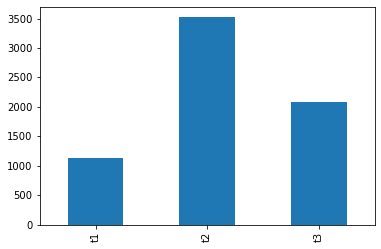

In [5]:
class_cnts = dfs["complete_train"][target].value_counts(dropna=False)
class_cnts.sort_index().plot(kind="bar")

In [6]:
def printDivisors(n): 
    i = 1
    n_w = n
    divs = []
    while (i <= n_w): 
        if (n_w % i==0) & (i >= 5) & (i <= 10):
            drop_n = n-n_w
            print("Int divisor for", n_w, "is", str(i)+". Drop", drop_n,"image groups.")
            return drop_n, i
        if (n_w == i):
            n_w -= 1
            i = 0
        i = i + 1

In [7]:
drop_n, cv_folds = printDivisors(len(dfs["complete_train"]))

Int divisor for 6730 is 5. Drop 0 image groups.


In [8]:
# Data prep for test set
dfs["complete_test"]["filename"] = dfs["complete_test"]["filename"].str.replace("^(tst_|vld_)|t\d|_add|_nadd", "").str.replace("_(?=.jpg)", "")
display(dfs["complete_train"].head(2), dfs["complete_test"].head(2))

,filename,'Auto Color Correlogram0','Auto Color Correlogram1','Auto Color Correlogram2','Auto Color Correlogram3','Auto Color Correlogram48','Auto Color Correlogram49','Auto Color Correlogram50','Auto Color Correlogram51','Auto Color Correlogram52','Auto Color Correlogram53','Auto Color Correlogram54','Auto Color Correlogram55','Auto Color Correlogram56','Auto Color Correlogram57','Auto Color Correlogram58','Auto Color Correlogram59','Auto Color Correlogram60','Auto Color Correlogram61','Auto Color Correlogram62','Auto Color Correlogram63','Spatial Pyramid of Local Binary Patterns0','Spatial Pyramid of Local Binary Patterns1','Spatial Pyramid of Local Binary Patterns2','Spatial Pyramid of Local Binary Patterns3','Spatial Pyramid of Local Binary Patterns4','Spatial Pyramid of Local Binary Patterns5','Spatial Pyramid of Local Binary Patterns6','Spatial Pyramid of Local Binary Patterns7','Spatial Pyramid of Local Binary Patterns8','Spatial Pyramid of Local Binary Patterns9','Spatial Pyramid of Local Binary Patterns10','Spatial Pyramid of Local Binary Patterns11','Spatial Pyramid of Local Binary Patterns12','Spatial Pyramid of Local Binary Patterns13','Spatial Pyramid of Local Binary Patterns14','Spatial Pyramid of Local Binary Patterns15','Spatial Pyramid of Local Binary Patterns16','Spatial Pyramid of Local Binary Patterns17','Spatial Pyramid of Local Binary Patterns18','Spatial Pyramid of Local Binary Patterns19','Spatial Pyramid of Local Binary Patterns20','Spatial Pyramid of Local Binary Patterns21','Spatial Pyramid of Local Binary Patterns22','Spatial Pyramid of Local Binary Patterns23','Spatial Pyramid of Local Binary Patterns24','Spatial Pyramid of Local Binary Patterns25','Spatial Pyramid of Local Binary Patterns26','Spatial Pyramid of Local Binary Patterns27','Spatial Pyramid of Local Binary Patterns29',...,PHOG581,PHOG582,PHOG583,PHOG584,PHOG585,PHOG586,PHOG587,PHOG588,PHOG589,PHOG590,PHOG591,PHOG592,PHOG593,PHOG594,PHOG595,PHOG596,PHOG597,PHOG598,PHOG599,PHOG600,PHOG601,PHOG602,PHOG603,PHOG604,PHOG605,PHOG606,PHOG607,PHOG608,PHOG609,PHOG610,PHOG611,PHOG612,PHOG613,PHOG614,PHOG615,PHOG616,PHOG617,PHOG618,PHOG619,PHOG620,PHOG621,PHOG622,PHOG623,PHOG624,PHOG625,PHOG626,PHOG627,PHOG628,PHOG629,class
0,trn_0_add_t2.jpg,11,8,7,5,15,15,15,15,15,15,14,14,15,14,14,13,15,15,14,14,0,0,0,0,3,0,0,0,15,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,15,10,6,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,t2
1,trn_1000_add_t1.jpg,6,4,4,3,15,15,14,14,15,15,14,14,15,15,15,14,15,15,15,15,0,0,0,0,3,0,0,0,15,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,2,0,1,5,0,1,8,12,5,13,15,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,4,3,9,15,11,6,3,4,t1


,filename,'Auto Color Correlogram0','Auto Color Correlogram1','Auto Color Correlogram2','Auto Color Correlogram3','Auto Color Correlogram48','Auto Color Correlogram49','Auto Color Correlogram50','Auto Color Correlogram51','Auto Color Correlogram52','Auto Color Correlogram53','Auto Color Correlogram54','Auto Color Correlogram55','Auto Color Correlogram56','Auto Color Correlogram57','Auto Color Correlogram58','Auto Color Correlogram59','Auto Color Correlogram60','Auto Color Correlogram61','Auto Color Correlogram62','Auto Color Correlogram63','Spatial Pyramid of Local Binary Patterns0','Spatial Pyramid of Local Binary Patterns1','Spatial Pyramid of Local Binary Patterns2','Spatial Pyramid of Local Binary Patterns3','Spatial Pyramid of Local Binary Patterns4','Spatial Pyramid of Local Binary Patterns5','Spatial Pyramid of Local Binary Patterns6','Spatial Pyramid of Local Binary Patterns7','Spatial Pyramid of Local Binary Patterns8','Spatial Pyramid of Local Binary Patterns9','Spatial Pyramid of Local Binary Patterns10','Spatial Pyramid of Local Binary Patterns11','Spatial Pyramid of Local Binary Patterns12','Spatial Pyramid of Local Binary Patterns13','Spatial Pyramid of Local Binary Patterns14','Spatial Pyramid of Local Binary Patterns15','Spatial Pyramid of Local Binary Patterns16','Spatial Pyramid of Local Binary Patterns17','Spatial Pyramid of Local Binary Patterns18','Spatial Pyramid of Local Binary Patterns19','Spatial Pyramid of Local Binary Patterns20','Spatial Pyramid of Local Binary Patterns21','Spatial Pyramid of Local Binary Patterns22','Spatial Pyramid of Local Binary Patterns23','Spatial Pyramid of Local Binary Patterns24','Spatial Pyramid of Local Binary Patterns25','Spatial Pyramid of Local Binary Patterns26','Spatial Pyramid of Local Binary Patterns27','Spatial Pyramid of Local Binary Patterns29',...,PHOG581,PHOG582,PHOG583,PHOG584,PHOG585,PHOG586,PHOG587,PHOG588,PHOG589,PHOG590,PHOG591,PHOG592,PHOG593,PHOG594,PHOG595,PHOG596,PHOG597,PHOG598,PHOG599,PHOG600,PHOG601,PHOG602,PHOG603,PHOG604,PHOG605,PHOG606,PHOG607,PHOG608,PHOG609,PHOG610,PHOG611,PHOG612,PHOG613,PHOG614,PHOG615,PHOG616,PHOG617,PHOG618,PHOG619,PHOG620,PHOG621,PHOG622,PHOG623,PHOG624,PHOG625,PHOG626,PHOG627,PHOG628,PHOG629,class
0,10000.jpg,13,12,10,10,15,15,15,14,15,14,14,13,15,14,14,13,15,15,15,15,0,1,2,0,6,0,0,0,15,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,1,0,...,9,9,9,8,8,10,9,9,9,11,12,13,14,14,15,11,13,11,11,3,7,15,11,12,8,8,7,6,5,3,4,2,3,3,5,6,4,5,3,7,2,6,7,11,11,8,9,12,8,None
1,10001.jpg,7,6,6,5,15,14,14,14,15,14,14,13,15,14,14,13,15,15,15,14,0,0,0,0,2,0,0,0,15,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,2,2,1,4,10,12,15,9,8,12,11,8,8,6,5,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,5,9,15,12,6,4,3,3,2,1,1,2,2,None


In [9]:
class_le = LabelEncoder().fit(dfs["complete_train"][target])
print(class_le.classes_, class_le.transform(class_le.classes_))
ml_data = dict()
sample_weights = dict()
cmplt_dmatrices = dict()
cv_dmtrc = dict()
for i in range(len([key for key in dfs.keys() if key.startswith("f")])//2):
    cv_dmtrc[i] = dict()

for df in dfs.keys():
    X_name = df+"_X"
    y_name = df+"_y"
    ml_data[X_name] = dfs[df][num_vnames]

    if df == "complete_test":
        cmplt_dmatrices[df] = xgb.DMatrix(ml_data[X_name].values, nthread=-1)
    else:
        ml_data[y_name] = dfs[df][target]
        ml_data[y_name] = pd.Series(class_le.transform(ml_data[y_name]), index=ml_data[y_name].index, dtype=np.uint8)
        sample_weights[y_name] = pd.Series(compute_sample_weight('balanced', ml_data[y_name]), index=ml_data[X_name].index)
        
        if df == "complete_train":
            cmplt_dmatrices[df] = xgb.DMatrix(ml_data[X_name].values, label=ml_data[y_name].values, weight=sample_weights[y_name], nthread=-1)
        else:
            fold_n = [int(s) for s in list(df) if s.isdigit()][0]            
            cv_dmtrc[fold_n][df] = xgb.DMatrix(ml_data[X_name].values, label=ml_data[y_name].values, weight=sample_weights[y_name], nthread=-1)
gc.collect()

['t1' 't2' 't3'] [0 1 2]


22

In [10]:
sample_weights.keys()

dict_keys(['complete_train_y', 'f0_train_y', 'f0_val_y', 'f1_train_y', 'f1_val_y', 'f2_train_y', 'f2_val_y', 'f3_train_y', 'f3_val_y', 'f4_train_y', 'f4_val_y'])

In [11]:
cmplt_dmatrices.keys()

dict_keys(['complete_test', 'complete_train'])

In [12]:
cv_dmtrc.keys(), cv_dmtrc[list(cv_dmtrc.keys())[0]].keys()

(dict_keys([0, 1, 2, 3, 4]), dict_keys(['f0_train', 'f0_val']))

In [13]:
display(ml_data['complete_train_X'].head(1), ml_data['complete_train_y'].head())

,'Auto Color Correlogram0','Auto Color Correlogram1','Auto Color Correlogram2','Auto Color Correlogram3','Auto Color Correlogram48','Auto Color Correlogram49','Auto Color Correlogram50','Auto Color Correlogram51','Auto Color Correlogram52','Auto Color Correlogram53','Auto Color Correlogram54','Auto Color Correlogram55','Auto Color Correlogram56','Auto Color Correlogram57','Auto Color Correlogram58','Auto Color Correlogram59','Auto Color Correlogram60','Auto Color Correlogram61','Auto Color Correlogram62','Auto Color Correlogram63','Fuzzy Opponent Histogram17','Fuzzy Opponent Histogram18','Fuzzy Opponent Histogram4','Fuzzy Opponent Histogram5','Fuzzy Opponent Histogram7','Fuzzy Opponent Histogram8','Fuzzy Opponent Histogram9','Gabor Features0','Gabor Features1','Gabor Features10','Gabor Features11','Gabor Features12','Gabor Features13','Gabor Features14','Gabor Features15','Gabor Features16','Gabor Features17','Gabor Features18','Gabor Features19','Gabor Features2','Gabor Features20','Gabor Features21','Gabor Features22','Gabor Features23','Gabor Features24','Gabor Features25','Gabor Features26','Gabor Features27','Gabor Features28','Gabor Features29',...,PHOG620,PHOG621,PHOG622,PHOG623,PHOG624,PHOG625,PHOG626,PHOG627,PHOG628,PHOG629,PHOG63,PHOG64,PHOG65,PHOG66,PHOG67,PHOG68,PHOG69,PHOG7,PHOG70,PHOG71,PHOG72,PHOG73,PHOG74,PHOG75,PHOG76,PHOG77,PHOG78,PHOG79,PHOG8,PHOG80,PHOG81,PHOG82,PHOG83,PHOG84,PHOG85,PHOG86,PHOG87,PHOG88,PHOG89,PHOG9,PHOG90,PHOG91,PHOG92,PHOG93,PHOG94,PHOG95,PHOG96,PHOG97,PHOG98,PHOG99
0,11,8,7,5,15,15,15,15,15,15,14,14,15,14,14,13,15,15,14,14,7,55,14,41,8,52,6,9.532,0.111,9.535,0.111,9.850,0.114,9.854,0.114,9.854,0.114,9.850,0.114,9.535,9.854,0.114,9.854,0.114,9.841,0.114,9.845,0.114,9.845,0.114,...,0,0,0,0,0,0,0,0,0,0,2,2,3,3,4,3,4,6,3,4,5,7,8,14,15,14,11,6,5,4,2,1,1,1,0,0,0,0,0,5,5,1,1,0,0,0,0,0,1,1


0    1
1    0
2    0
3    1
4    0
dtype: uint8

In [14]:
params = {
    # Parameters that we are going to tune.
    'booster': "gbtree",
    'max_depth': 6,
    'max_leaves': 0,
    'eta': 0.3,
    'subsample': 1,
    'colsample_bytree': 1,
    
    # Other parameters
    'tree_method': 'hist',
    'grow_policy': 'lossguide',
    'objective': 'multi:softprob',
    'eval_metric': 'mlogloss',
    'num_class': len(class_le.classes_)}

# Global variables
ITERATION = 0
max_trees = 1000
EARLY_STOP = 5

In [24]:
def objective(param):
    """Objective function for Gradient Boosting Machine Hyperparameter Optimization"""
    
    # Keep track of evals
    global ITERATION
    ITERATION += 1
    
    cv_res = dict()
    cv_models = dict()
    
    # Make sure parameters that need to be integers are integers
    for parameter_name in param:
        if parameter_name in ["max_depth", "max_leaves"]:
            param[parameter_name] = int(param[parameter_name])
    
    start = timer()
    
    # Perform n_folds cross validation
    if ITERATION % (EARLY_STOP*2) == 0:
        gc.collect()
    
    for fold in cv_dmtrc.keys():
        cv_res[fold] = dict()
        fld_name_trn, fld_name_val = 'f'+str(fold)+'_train', 'f'+str(fold)+'_val'
        
        cv_models[fold] = xgb.train(params=param, dtrain=cv_dmtrc[fold][fld_name_trn], num_boost_round=max_trees,
                                    evals=[(cv_dmtrc[fold][fld_name_val], "val")],  # (cv_dmtrc[fold][fld_name_trn], "train")
                                    early_stopping_rounds=EARLY_STOP, evals_result=cv_res[fold], verbose_eval=False)
    
    run_time = timer() - start
    
    # Constructing dataframe from dict results
    d = {(i, j, k): cv_res[i][j][k]
         for i in cv_res.keys()  # fold
         for j in cv_res[i].keys()  # train/val
         for k in cv_res[i][j].keys()} # error values
    mux = pd.MultiIndex.from_tuples(d.keys())
    cv_res_df = pd.DataFrame(list(d.values()), index=mux).T
    
    # Best error and n_trees
    fold_errors = dict()
    n_estimators = dict()
    for fold in cv_res_df.columns.get_level_values(0).drop_duplicates():
        f_error = cv_res_df[fold]["val"].squeeze().dropna()
        f_error = f_error[f_error == f_error.min()]
        fold_errors[fold] = f_error.values[0]
        n_estimators[fold] = f_error.index.values[0]+1

    best_score = pd.Series(list(fold_errors.values())).mean()
    best_n_trees = int(pd.Series(list(n_estimators.values())).mean().round())

    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a', newline="")
    writer = csv.writer(of_connection, delimiter=',')
    writer.writerow([best_score, param, ITERATION, best_n_trees, run_time])
    
    # Dictionary with information for evaluation
    return {'loss': best_score, 'param': param, 'iteration': ITERATION,
            'estimators': best_n_trees, 
            'train_time': run_time, 'status': STATUS_OK}

In [25]:
# test_dct = {'max_leaves': hp.uniform('max_leaves', 15, np.iinfo(np.uint32).max-1),}
# temp_lst = []
# for i in range(10000):
#     temp_lst += [sample(test_dct)['max_leaves']]
# temp_lst = pd.Series(temp_lst).sort_values().reset_index(drop=True)
# temp_lst.value_counts().sort_index().plot(kind="area")

In [30]:
# Define the search space
def space():
    prmtrs = dict()
    prmtrs['booster'] = sample(hp.choice('booster', ['dart', 'gbtree'])) # , 'gblinear'
    
    if prmtrs['booster'] != 'gblinear':
        # ints
        prmtrs['max_depth'] = hp.uniform('max_depth', 1, 20)
#         prmtrs['max_leaves'] = hp.uniform('max_leaves', 1, 4095)

        # floats
        prmtrs['subsample'] = hp.uniform('subsample', 0.5, 1.0)
        prmtrs['colsample_bytree'] = hp.uniform('colsample_by_tree', 0.25, 1.0)
        
        # other pars
        prmtrs['grow_policy'] = 'lossguide'
        prmtrs['tree_method'] = 'hist'
    
    #floats
    prmtrs['eta'] = hp.uniform('eta', 0.01, 0.2)
    
    # Other parameters
    prmtrs['objective'] = 'multi:softprob'
    prmtrs['eval_metric'] = 'mlogloss'
    prmtrs['num_class'] = len(class_le.classes_)
    return prmtrs


# Sample from the full space
example = sample(space())

print(example)

{'booster': 'dart', 'colsample_bytree': 0.46082859215417826, 'eta': 0.031178953418270768, 'eval_metric': 'mlogloss', 'grow_policy': 'lossguide', 'max_depth': 18.1791297959294, 'num_class': 3, 'objective': 'multi:softprob', 'subsample': 0.9623636716911621, 'tree_method': 'hist'}


In [31]:
# Keep track of results
bayes_trials = Trials()

# File to save first results
out_file = models_path+gbm_trials_fname
of_connection = open(out_file, 'w', newline="")
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'params', 'iteration', 'estimators', 'train_time'])
of_connection.close()

In [ ]:
# Run optimization
MAX_EVALS = 100

start_time = pd.to_datetime("now")
print("Start time", start_time.strftime(dt_ftm))

best = fmin(fn=objective, space=sample(space()), algo=tpe.suggest, max_evals=MAX_EVALS,  trials=bayes_trials, rstate=np.random.RandomState(123))

finish_time = pd.to_datetime("now")
print("Finish time", finish_time.strftime(dt_ftm), "or", round((finish_time-start_time).seconds/60), "minutes.\n")

In [ ]:
# Sort the trials with lowest loss (lower mlogloss) first
bayes_trials_results = sorted(bayes_trials.results, key = lambda x: x['loss'])
for cfg in bayes_trials_results[:3]:
    pprint(cfg)

In [ ]:
# Open the results again
results = pd.read_csv(models_path+gbm_trials_fname)
print('These parameters were discovered through {} search iterations'.format(results['iteration'].max()))

# Sort values with best on top and reset index for slicing
results.sort_values('loss', ascending = True, inplace = True)
results.reset_index(inplace = True, drop = True)
results.head()

In [ ]:
# Extract the ideal number of estimators and hyperparameters
best_bayes_estimators = int(results.loc[0, 'estimators'])
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()

In [22]:
# Re-create the best model and train on the training data
xgb_model_evals_res = dict()
xgb_model = xgb.train(params=params, dtrain=xgtrain, num_boost_round=max_trees, evals=[(xgtrain, "train")],  # best_bayes_params, best_bayes_estimators
                             evals_result=xgb_model_evals_res, verbose_eval=10)

xgb_model.save_model(models_path+'current_best.xgb')
# xgb_model.dump_model(models_path+'current_best_xgb'+'_raw.txt', models_path+'current_best_xgb'+'_featmap.txt')
with open(models_path+'current_best_xgb'+'_cfg.json', 'w') as outfile:
    json.dump(xgb_model.save_config(), outfile)

[0]	train-mlogloss:0.79970
[10]	train-mlogloss:0.09725


In [23]:
#Predict test set:
predictions = dict()
for n_trees in [11]: # range(max_trees, int(max_trees//8)-1, -int(max_trees//8)):
    predictions[n_trees] = pd.DataFrame(xgb_model.predict(xgtest, ntree_limit=n_trees))
    predictions[n_trees].columns = pd.Series(class_le.inverse_transform(predictions[n_trees].columns.tolist())).str.replace("t", "Type_")
    predictions[n_trees] = pd.concat([test_data["filename"].rename("image_name"), predictions[n_trees]], axis=1)
    predictions[n_trees].to_csv(predictions_path+"xgb_pred_"+str(n_trees)+".csv", index=False)

In [24]:
predictions[n_trees].head()

,image_name,Type_1,Type_2,Type_3
0,100.jpg,0.894,0.063,0.043
1,103.jpg,0.902,0.044,0.054
2,111.jpg,0.923,0.043,0.034
3,123.jpg,0.916,0.048,0.036
4,142.jpg,0.937,0.032,0.031


In [65]:
# # load JS visualization code to notebook
# shap.initjs()

# shap_ind = X_test.sample(n=1000, random_state=123).index
# shap_xgb_X = X_test.loc[shap_ind]
# # shap_xgb_y = y_train.loc[shap_ind]

In [66]:
# explainer = shap.TreeExplainer(xgb_model)
# shap_values = explainer.shap_values(shap_xgb_X)

In [67]:
# # summarize the effects of all the features
# shap.summary_plot(shap_values, shap_xgb_X)